In [1]:
import sys
import os
import pandas as pd
import numpy as np
import warnings
import sklearn
warnings.filterwarnings('ignore')

TRAIN_PATH = "../../data/train.csv"
TEST_PATH = "../../data/test.csv"

def get_data(path):
    data = pd.read_csv(path)
    return data

In [2]:
data = get_data(TRAIN_PATH)
#基本処理
#カテゴリ変数のダミー化
cat = data.filter(regex="cat").columns
bin = data.filter(regex="bin").columns
cat = cat.append(bin)
non_cat = list(set(data.columns) - set(cat))

for tag in cat:
    data[tag] = data[tag].astype(str)
data = pd.concat((data, pd.get_dummies(data[cat])), axis=1).drop(cat,axis=1)

#欠損値の存在するnon_cat値
for tag in non_cat:
    data[tag][data[tag]==-1] = data[tag][data[tag]!=-1].mean()
    
from sklearn.model_selection import train_test_split
target = data.target.values
data = data.drop(['id', 'target'], axis=1)
data = data.values
print(target.shape, data.shape)

#X_train, X_test, Y_train, Y_test = train_test_split(data, target, stratify=target, random_state=0)

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(data)
data = sc.transform(data)

(595212,) (595212, 244)


In [2]:
import numpy as np

def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ],dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses

    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)
 
def gini_normalized(a, p):
    return gini(a, p) / gini(a, a)

In [5]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor(n_jobs=4)
forest.fit(data_resam, target_resam)
#result=forest.predict(data)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=4,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [8]:
result=forest.predict(data_resam)

In [6]:
#standard
gini_normalized(target, result)

1.0

In [6]:
#分類器の保存
from sklearn.externals import joblib

joblib.dump(forest, 'forest.cmp', compress=True)

['forest.cmp']

In [2]:
data_sub = get_data(TEST_PATH)
#提出データ側
#基本処理
#カテゴリ変数のダミー化
cat = data_sub.filter(regex="cat").columns
bin = data_sub.filter(regex="bin").columns
cat = cat.append(bin)
non_cat = list(set(data_sub.columns) - set(cat))

for tag in cat:
    data_sub[tag] = data_sub[tag].astype(str)
data_sub = pd.concat((data_sub, pd.get_dummies(data_sub[cat])), axis=1).drop(cat,axis=1)

#欠損値の存在するnon_cat値
for tag in non_cat:
    data_sub[tag][data_sub[tag]==-1] = data_sub[tag][data_sub[tag]!=-1].mean()
    
id = data_sub.id.values
data_sub = data_sub.drop('id', axis=1)
data_sub = data_sub.values
print(id.shape, data_sub.shape)

from sklearn.preprocessing import StandardScaler
sc_sub = StandardScaler()
sc_sub.fit(data_sub)
data_sub = sc_sub.transform(data_sub)

(892816,) (892816, 244)


In [3]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler()
data_resam, target_resam = ros.fit_sample(data, target)
del data, target

In [3]:
from sklearn.externals import joblib
forest = joblib.load('forest.cmp')
result = forest.predict(data_sub)

In [11]:
np.where(result > 0.5)

(array([   903,    971,   2445,   2780,   4483,   7624,   7837,  10609,
         10783,  10788,  11085,  12892,  13251,  14150,  14477,  14859,
         15136,  15989,  16530,  19410,  19443,  20470,  20917,  22138,
         24236,  25608,  26662,  27308,  28725,  29796,  30956,  30969,
         31117,  32648,  33490,  33871,  34049,  37085,  37213,  38136,
         38495,  39947,  39958,  41028,  41740,  44475,  45298,  46215,
         47397,  48469,  49547,  50012,  52558,  54081,  54905,  55063,
         55510,  56205,  56413,  56755,  57719,  60244,  60291,  60438,
         61575,  62018,  62378,  64546,  64799,  65186,  68043,  68934,
         69377,  69477,  69761,  70117,  70603,  71003,  71829,  73924,
         76301,  76691,  77377,  77637,  80301,  80829,  81634,  84753,
         84875,  85402,  85461,  85989,  88237,  89070,  92935,  93118,
         93152,  93248,  93580,  93914,  94665,  98078, 100124, 100827,
        100901, 102163, 102632, 103096, 104017, 104141, 104362, 

In [5]:
f = open('result.csv', 'w') # 書き込みモードで開く

for i in range(len(id)):
    f.write(str(id[i])+','+str(result[i])+'\n')
    
f.close() # ファイルを閉じる

In [8]:
from sklearn.ensemble import AdaBoostClassifier

clf = AdaBoostClassifier(learning_rate=1.0)
clf.fit(X_train_std, Y_train)
print("train:",clf.__class__.__name__ ,clf.score(X_train_std,Y_train))
print("test:",clf.__class__.__name__ , clf.score(X_test_std,Y_test)) # 若干、オーバーフィッティングしている

train: AdaBoostClassifier 0.960666666667
test: AdaBoostClassifier 0.952


In [12]:
# パラメータを設定してループでまわす
score_list = []

for r in np.arange(0.00001,2,0.01):    
    clf = AdaBoostClassifier(learning_rate=r)
    clf.fit(X_train, Y_train)
    score_list.append([r,clf.score(X_test,Y_test)])
    
score_list_df = pd.DataFrame(score_list)
score_list_df.columns= ["r","score"]

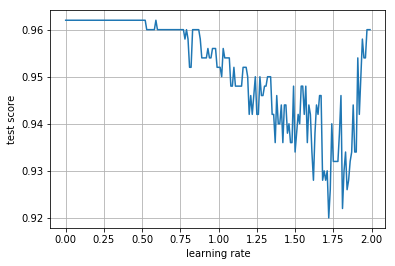

In [13]:
import matplotlib.pyplot as plt
plt.plot(score_list_df.r,score_list_df.score)
plt.xlabel("learning rate")
plt.ylabel("test score")
plt.grid(True)
plt.show()

Index(['ps_car_13', 'ps_reg_03', 'ps_car_14', 'ps_calc_10', 'ps_calc_01',
       'ps_calc_11', 'ps_ind_03', 'ps_car_15', 'ps_reg_02', 'ps_ind_15',
       ...
       'ps_ind_02_cat_-1', 'ps_car_11_cat_56', 'ps_ind_13_bin_0',
       'ps_car_04_cat_4', 'ps_ind_10_bin_1', 'ps_ind_10_bin_0',
       'ps_car_11_cat_97', 'ps_ind_04_cat_-1', 'ps_car_11_cat_30',
       'ps_car_10_cat_2'],
      dtype='object', length=243)

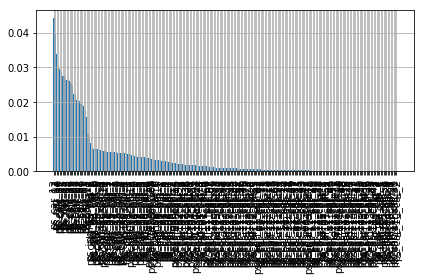

In [68]:
%matplotlib inline
importances = model.feature_importances_
indi = np.argsort(importances)[::-1]

plt.bar(range(X_train.shape[1]),importances[indi])
plt.xticks(range(X_train.shape[1]),label[indi],rotation=90)
plt.grid(True)
plt.tight_layout()

label[indi]

In [25]:
from sklearn.svm import SVR
model = SVR(kernel='rbf',  C=2)


clf = model.fit(X_train_std, Y_train)

print("train:",clf.__class__.__name__ ,clf.score(X_train_std,Y_train))
print("test:",clf.__class__.__name__ , clf.score(X_test_std,Y_test))

train: SVR 0.676857045919
test: SVR -0.213883515482
